In [7]:
import uproot4
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
import awkward1 as ak
from lxml import etree as ET
import os
from pathlib import Path
import pandas as pd
import numpy as np
import time

from event_display import get_module_geometry, get_module_positions, plot_calorimeter_hits, build_calorimeter_section
from geant3_parser import Geant3DataFile, build_train_set_xy

In [8]:
file_name = os.path.join('data', 'shower_geant3_new.dat')


# file_name = 'sample_data.txt'
data_file = Geant3DataFile(file_name, skip_lines=3)

# split into input (X) and output (y) variables
parse_start = time.time()
print(f"Start preparing events...")


cells, true_values = build_train_set_xy(data_file, 5000, normalize=True)
parse_end = time.time()

print(f"Total events prepare time = {parse_end - parse_start}")
print(f"max hit value = {np.max(cells)}")
print(f"max e = {np.max(true_values[:,0])}")
print(f"Inputs shape original = {np.shape(cells)}")

# Reshape it to 11x11x1
cells = np.reshape(cells, (len(cells), 11, 11, 1))  # -1 => autodetermine

# Pad with 1 row and column of zeroes, so it divides by 2
# inputs = np.pad(inputs, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)
print(f"Inputs shape new = {np.shape(cells)}")


energies = true_values[:, 0]        # True energy of the particle
cell_sums = true_values[:, 1]       # Sum of all cells (you don't need it)
incident_x = true_values[:, 2]      # X of incidence inside the cell 
incident_y = true_values[:, 3]      # Y 

Time open 0.35092759132385254
Time split 0.2915961742401123
Start preparing events...
Total events prepare time = 0.16317129135131836
max hit value = 0.7586345789791428
max e = 5.4983
Inputs shape original = (5000, 121)
Inputs shape new = (5000, 11, 11, 1)


In [9]:
def display_event(event_data, fig=None, ax=None, cal_size=11, cell_size=1):
    # constants
    size_x = cell_size
    size_y = cell_size
    dx = size_x / 2.0
    dy = size_y / 2.0

    # go through all cells and calculate their centers
    centers = np.arange(-cal_size/2.0 + cell_size/2, cal_size/2 + cell_size/2, 1)
    positions = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            positions.append((centers[x_iter], centers[y_iter]))

    # plot calorimeter with empty cells
    if not fig or not ax:
        fig, ax = plt.subplots()
    build_calorimeter_section(ax, positions, 1, 1)

    # Create a heat map
    norm = LogNorm()
    norm.autoscale(event_data)
    cmap = cm.get_cmap('inferno')

    # Convert data to rectangular patches    
    module_rects = []
    for y_iter in range(cal_size):
        for x_iter in range(cal_size):
            x = centers[x_iter]
            y = centers[y_iter]
            weight = event_data[x_iter][y_iter][0]
            #print(x,y,weight)
            patch = patches.Rectangle((x-dx, y-dy), size_x, size_y, edgecolor='black', facecolor=cmap(norm(weight)))
            module_rects.append(patch)

    # plot rectangles with data
    col = PatchCollection(module_rects, match_original=True)
    ax.add_collection(col)

    # plot heatmap legend
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(event_data)
    fig.colorbar(sm)
    
    return fig, ax

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

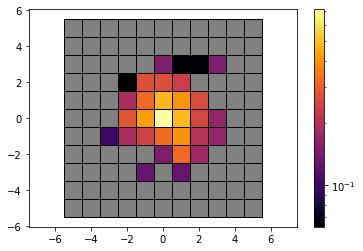

In [12]:
display_event(cells[8])
